In [2405]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2406]:
import pickle, gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from scipy import ndimage
import random

In [2407]:
path_to_flatland_train_data = 'data/flatland_train.data'

In [2408]:
X, y = pickle.load(gzip.open(path_to_flatland_train_data, 'rb'))
# X - data of images
# y - image labels referenced as the number of corners the shape has
# Circle has 0 corners.

In [2409]:
X.shape

(10000, 50, 50)

In [2410]:
y.shape

(10000,)

In [2411]:
np.unique(y)

array([0., 3., 4., 5., 6.])

In [2412]:
y=np.where(y>0,y-2,y)
np.unique(y)

array([0., 1., 2., 3., 4.])

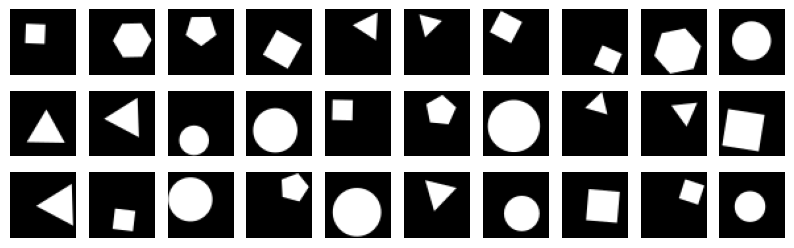

In [2413]:
plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
plt.show()

# Data modification
The models seem to look beyond the borders at the black background. We will attempt to fix that by highlighting the edges of the shapes.

In [2414]:
def highlight_edges(image):
  #Sobel filter
  dx = ndimage.sobel(image,1)
  dy = ndimage.sobel(image,0)
  edges = np.hypot(dx,dy)
  edges = (edges - edges.min()) / (edges.max() - edges.min())
  edges[edges < 0.8] = 0
  # Can make edges thicker or thinner. (Greater value = thinner)
  # The model will potentially be more sensitive to very thin edges.

  return edges

In [2415]:
X_highlight = np.array([highlight_edges(image) for image in X])

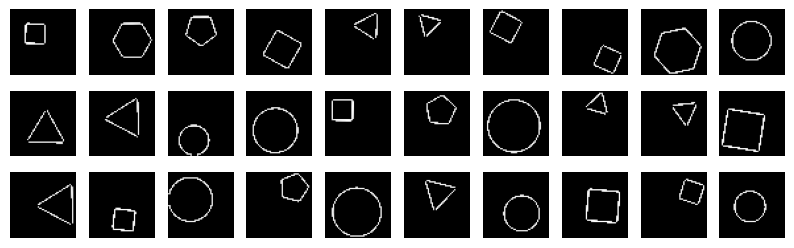

In [2416]:
plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X_highlight[i], cmap='gray')
    plt.axis('off')
plt.show()

In [2417]:
X = X_highlight

Upon trying a new model, the saliency shows the model is looking much much less at the black background. This, however changes when a batchnorm is applied.

# More artifical data: Rotations
We can give the model more training data and make it easier for it to recognize shapes in different rotations.
We can increase the size of the dataset by 4 by Flipping Horizontally, Flipping Vertically, Flipping Horizontally & Vertically.

In [2418]:
augmented_data = []

for image in X:
    augmented_data.append(image) 
    augmented_data.append(np.flip(image, axis=1))  # Horizontal flip
    augmented_data.append(np.flip(image, axis=0))  # Vertical flip
    augmented_data.append(np.flip(image, axis=(0,1)))  # Horizontal & vertical flip

# Stack all images to create the final augmented dataset
augmented_data = np.stack(augmented_data)  # Shape will be (40000, 50, 50)


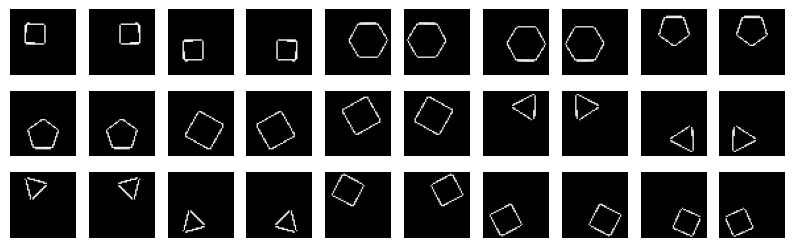

In [2419]:
plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(augmented_data[i], cmap='gray')
    plt.axis('off')
plt.show()

In [2420]:
X = augmented_data
y = np.repeat(y,4)

# Model

In [2421]:
training_images = torch.from_numpy(X).float()
training_labels = torch.from_numpy(y).long()

train_dataset = TensorDataset(training_images.unsqueeze(1), training_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_size = int(0.9 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [2422]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 12 * 12, 32)
        self.fc2 = nn.Linear(32, 5)
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.2)
        self.drop3 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.drop1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)
        x = x.view(x.shape[0], -1)
        x = self.drop3(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The model likes dropouts right before a relu, especially big dropouts, but it starts hating dropouts when BatchNorm is introduced earlier, dropouts then must be reduced to a smaller value. If the dropout is too small, it starts to diverge. Similarly if it's too big, it diverges.

In [2423]:
model = Network()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# Increase convergance speed through scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Network(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2304, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=5, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [2424]:
epochs = 25
losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss/len(train_loader))
    scheduler.step()
    print(f"Epoch [{epoch + 1}/{epochs}], running_loss: {running_loss/len(train_loader)}")

Epoch [1/25], running_loss: 1.1123534829904003
Epoch [2/25], running_loss: 0.7079096774682931
Epoch [3/25], running_loss: 0.4691565935070633
Epoch [4/25], running_loss: 0.2978557744558821
Epoch [5/25], running_loss: 0.2242804856059399
Epoch [6/25], running_loss: 0.1908505602297208
Epoch [7/25], running_loss: 0.17566354054931207
Epoch [8/25], running_loss: 0.1594821796719487
Epoch [9/25], running_loss: 0.14794624559845485
Epoch [10/25], running_loss: 0.1444217675491005
Epoch [11/25], running_loss: 0.12166924898823102
Epoch [12/25], running_loss: 0.11945568519175476
Epoch [13/25], running_loss: 0.1194377027927561
Epoch [14/25], running_loss: 0.11579563479262886
Epoch [15/25], running_loss: 0.11521498076881923
Epoch [16/25], running_loss: 0.11343175817465952
Epoch [17/25], running_loss: 0.11242773044352414
Epoch [18/25], running_loss: 0.11414418155525594
Epoch [19/25], running_loss: 0.11101083864345618
Epoch [20/25], running_loss: 0.10843934581106436
Epoch [21/25], running_loss: 0.1089808

Different dropout rates will require different number of epochs. Potentially best to add a break in the loop to stop after reaching a certain running_loss.

In [2425]:
model.eval()
incorrect_images = []
incorrect_labels = []
predicted_labels = []


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

        incorrect_images.extend(images[incorrect_indices].cpu())
        incorrect_labels.extend(labels[incorrect_indices].cpu())
        predicted_labels.extend(predicted[incorrect_indices].cpu())

test_accuracy = 100 * (len(test_dataset) - len(incorrect_images)) / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Bad guesses: {len(incorrect_images)}")

Test Accuracy: 98.40%
Bad guesses: 64


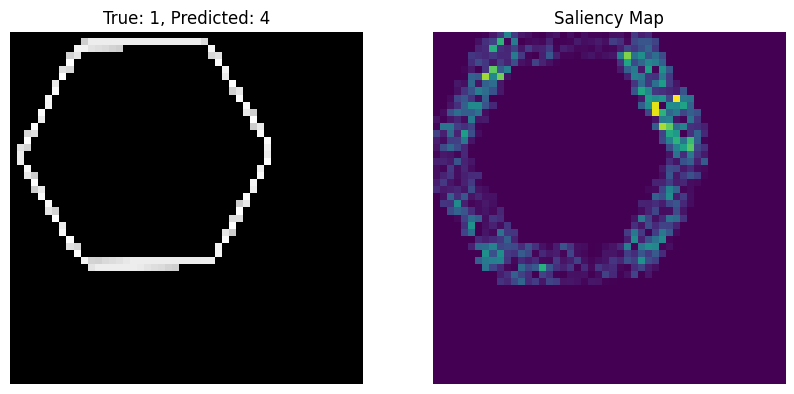

In [2426]:
index = 25

image = incorrect_images[index].unsqueeze(0).to(device)
image.requires_grad_()

model.eval()
output = model(image)
softmaxed_predictions = F.softmax(output,dim=1)
_, predicted_class = torch.max(output, 1)

output[:, predicted_class].backward()
gradients = image.grad.data.abs().squeeze()
gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(incorrect_images[index].squeeze(), cmap='gray')
plt.title(f"True: {incorrect_labels[index].item()}, Predicted: {predicted_labels[index].item()}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradients.cpu())
plt.title("Saliency Map")
plt.axis('off')

plt.show()

In [2427]:
torch.save(model,'saved_models/model_iter5.pth')

# Submission Prediction String
Note: Model is predicting -2 offset for shapes with corners >0.
With model_iter2 being 39MB(Quite big! Should've done fewer epochs), we need to do predictions in batches to not run out of memory.

In [2428]:
tr_x, _ = pickle.load(gzip.open('data/flatland_test.data', 'rb'))
tr_x = np.array([highlight_edges(image) for image in tr_x])
tr_x = torch.from_numpy(tr_x).float()

dataset = TensorDataset(tr_x.unsqueeze(1))
data_loader = DataLoader(dataset, batch_size=128, shuffle=False)

loaded_model = torch.load('saved_models/model_iter5.pth')
loaded_model.to(device)
loaded_model.eval()

all_predictions = []

with torch.no_grad():  
    for batch in data_loader:
        batch_data = batch[0].to(device)
        batch_predictions = loaded_model(batch_data)
        all_predictions.append(batch_predictions)

all_predictions = torch.cat(all_predictions)

_, predicted_class = torch.max(all_predictions, 1)

predicted_class = torch.where(predicted_class != 0, predicted_class + 2, predicted_class)

predicted_class = predicted_class.cpu().numpy()

C:\Users\Audrius\AppData\Local\Temp\ipykernel_2372\1366369626.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('saved_models/model_iter5.pth')


In [2429]:
print(''.join([str(round(p)) for p in predicted_class]))

6645533343400003340545465645540453050355060333004353304356604004553303655503043350530654000355355463530403305345345040035300650004555530445455543654345046545635035036546303536656365600300305505463530335303336330465353306053506453360450054500063445060340043400453533430440546354503340300344553655053533306444055303443403030005300004055506334500544330054304500443044350645463346000306504305453645043350533336630330600644345554354530053644433003304055544504505345553050664300303444544504030306344006554333400506436544330334035643434343650403330363543435603556403440550043403430450565605303434536054355435035004453056464500030403330463455364406563043554443345350503053500660654533336350334356344353343060333043443433504546433334030030054450544503643600503355633056300553303033030463444450546453433660005604345450536403330035505464006564430553033355340544530033043635653364030035430440356634344063550033036433354500635035440504640045344340300630645656404363635646435404000560355305364503035300453665355004